Douglas Rachford Proximal Splitting
===================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


This numerical tour presents the Douglas-Rachford (DR) algorithm to
minimize the sum of two simple functions. It shows an
application to
reconstruction of exactly sparse signal from noiseless measurement using
$\ell^1$ minimization.

In [174]:
source("nt_toolbox/general.R")
source("nt_toolbox/signal.R")
source("nt_toolbox/norms.R")
library(pracma)

Douglas-Rachford Algorithm
--------------------------
The Douglas-Rachford (DR) algorithm is an iterative scheme to minimize
functionals of the form
$$ \umin{x} F(x) + G(x) $$
where $F$ and $G$ are convex functions for which one is able to
comptue the proximal mappings $ \text{prox}_{\gamma F} $ and
$ \text{prox}_{\gamma G} $ which are defined as
$$ \text{prox}_{\gamma F}(x) = \text{argmin}_{y} \frac{1}{2}\norm{x-y}^2 + \ga F(y) $$
(the same definition applies also for $G$).


The important point is that $F$ and $G$ do not need to be smooth.
One only needs them to be "proximable".


This algorithm was introduced in:


P. L. Lions and B. Mercier
_Splitting Algorithms for the Sum of Two Nonlinear Operators_
SIAM Journal on Numerical Analysis
Vol. 16, No. 6 (Dec., 1979), pp. 964-979


as a generalization of an algorithm introduced by Douglas and Rachford in
the case of quadratic minimization (which corresponds to the solution of
a linear system).


To learn more about this algorithm, you can read:


Patrick L. Combettes and Jean-Christophe Pesquet,
_Proximal Splitting Methods in Signal Processing_,
in: Fixed-Point Algorithms for Inverse
Problems in Science and Engineering, New York: Springer-Verlag, 2010.



A DR iteration reads
$$ \tilde x_{k+1} = \pa{1-\frac{\mu}{2}} \tilde x_k +
  \frac{\mu}{2} \text{rprox}_{\gamma G}( \text{rprox}_{\gamma F}(\tilde x_k)  )
  \qandq x_{k+1} = \text{prox}_{\gamma F}(\tilde x_{k+1},) $$



We have used the following shortcuts:
$$   \text{rprox}_{\gamma F}(x) = 2\text{prox}_{\gamma F}(x)-x $$


It is of course possible to inter-change the roles of $F$ and $G$,
which defines another set of iterations.


One can show that for any value of $\gamma>0$, any $ 0 < \mu < 2 $,
and any $\tilde x_0$, $x_k \rightarrow x^\star$
which is a minimizer of the minimization of $F+G$.

Compressed Sensing Acquisition
------------------------------
Compressed sensing acquisition corresponds to a random projection
$y=Ax_0$ of a signal $x_0$ on a
few linear vectors (the lines of $A$). For the recovery of $x_0$ to be possible, it is assumed
to be sparsely represented in an orthogonal basis. Up to a change of
basis, we suppose that the vector $x$ itself is sparse.


Initialize the random number generator to have always the same signals.

In [175]:
set.seed(1)

Dimension of the problem.

In [176]:
n = 400

Number of measurements.

In [177]:
p = round(n/4)

Create a random Gaussian measurement matrix $A$.

In [178]:
A = randn(p,n) / sqrt(p)

Sparsity of the signal.

In [179]:
s = 17

We begin by generating a $s$-sparse signal $x_0$ with $s$ randomized values.
Since the measurement matrix is random, one does not care about the sign
of the Diracs, so we use +1 values.

In [180]:
sel = sample(c(1 : n))
x0 = zeros(n, 1)
x0[sel[1:s]] = 1

We perform random measurements $y=Ax_0$ without noise.

In [181]:
y = A %*% x0

Compressed Sensing Recovery using DR
------------------------------------
Compressed sensing recovery corresponds
to solving the inverse problem $y=A x_0$, which is ill posed because
$x_0$ is
higher dimensional than $y$.


The reconstruction can be perform with $\ell^1$ minimization,
which regularizes the problems by using the sparsity of the solution.
$$ x^\star \in \uargmin{ A x = y } \norm{x}_1 $$
where the $\ell^1$ norm is defined as
$$ \norm{x}_1 = \sum_i \abs{x_i}. $$


This is the minimization of a non-smooth function under affine
constraints. This can be shown to be equivalent to a linear programming
problem, for wich various algorithms can be used (simplex, interior
points). We propose here to use the DR iterative algorithm.


It is possible to recast this problem as the minimization of $F+G$
where $G(x) = \norm{x}_1$ and $F(x)=\iota_{H}$ where $H =
\enscond{x}{Ax=y}$ is an affine space, and $\iota_H$ is the indicator
function
$$ \iota_H(x) = \choice{ 0 \qifq x \in H, \\ +\infty \qifq x \notin H. } $$


The proximal operator of the $\ell^1$ norm is the soft thresholding:
$$ \text{prox}_{\gamma \norm{\cdot}_1}(x)_i = \max\pa{ 0, 1-\frac{\ga}{\abs{x_i}} } x_i. $$

In [182]:
proxG = function(x, gamma) {x * pmax(1 - ((gamma) / abs(x)), 0)}

Display the 1-D curve of the thresholding.

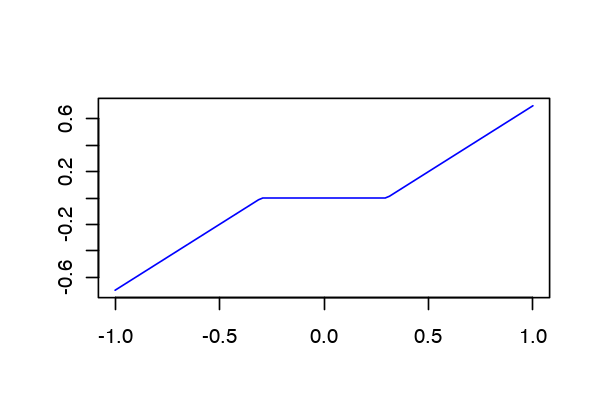

In [183]:
options(repr.plot.width=5, repr.plot.height=3.5)
t = linspace(-1,1)
plot(t, proxG(t, 0.3), type="l", col="blue", ylab="", xlab="")

The proximal operator of the indicator function of $H$ is the
projector, and does not depends on $\gamma$.
$$ \text{prox}_{\gamma \iota_H}(x)_i = \text{prox}_F(x) = x + A^* (A A^*)^{-1} (y-Ax). $$

In [184]:
pA = t(A) %*% solve(A%*% t(A))
proxF = function(x,y){x + pA %*% (y - A %*% x)}

There are two kinds of Douglas-Rachford iterations, depending on wether
you first apply the projection or the thresholding.


The first algorithm, (DR1), reads:
$$ \tilde x_{k+1} = \pa{1-\frac{\mu}{2}} \tilde x_k + \frac{\mu}{2} \text{rprox}_F( \text{rprox}_\gamma(\tilde x_k)  )
\qandq x_k = \text{prox}_\gamma(\tilde x_k) $$


The second algorithm, (DR2), reads:
$$ \tilde x_{k+1} = \pa{1-\frac{\mu}{2}} \tilde x_k + \frac{\mu}{2} \text{rprox}_{\gamma G}( \text{rprox}_F(\tilde x_k)  )
\qandq x_k = \text{Prox}_F(\tilde x_k) $$


The advantage of (DR2) is the the iterates $x_k$ always satisfy
$Ax_k=y$, so that one can only keep track of the evolution of the
$\ell^1$ norm during the iterations. We will use only (DR2) in the
following.


Set the value of $\mu$ and $\gamma$.
You might consider using your own value to speed up the convergence.

In [185]:
mu = 1
gamma = 1

Define the rprox operators.

In [186]:
rproxG = function(x,tau){2 * proxG(x,tau) - x}
rproxF = function(x, tau){2 * proxF(x,tay) - x}

Number of iterations.

In [187]:
niter = 500

__Exercise 1__

Implement the DR iterative algorithm on |niter| iterations.
Keep track of the evolution of the $\ell^1$ norm.

In [188]:
# Insert your code here

We display the convergence speed of the $\ell^1$ norm on the first half iterations, in log
scales.

In [189]:
# Insert your code here.

Display the original and the recovered signals.
Since the original signal is highly sparse, it is perfectly recovered.

In [190]:
# Insert your code here.

__Exercise 2__

Test the recovery of a less sparse signal.
What do you observe ?

In [191]:
# Insert your code here.

Evaluation of the CS Recovery Probability
-----------------------------------------
In order to bench in a randomized manner the efficiency of compressed
sensing, we compute the probability $p_s$ for a $s$-sparse signal
with random non-zero coefficient locations to be recovered by $\ell^1$
minimization.


Put formally, if we call $ x^\star(y) $ the resolution of the $\ell^1$
problem using measurements $y$, then we want to compute with
Monte-Carlo sampling
$$ p_s = \mathbb{P}( x^\star(Ax)=x \:\backslash\: \norm{x}_0=s ) $$


An important feature of the DR algorithm is that it can be run on many
signal at once.


Number of signals.

In [192]:
q = 1000

List of benched sparsity.

In [193]:
slist = seq(14, 42, 2)

List of sparsity of each signal

In [194]:
Slist = slist[mod(c(1 : q), length(slist)) + 1]

# Genetate signals so that |x0(:,j)| has sparsity |Slist(j)|.
U = rand(n,q)
v = c(apply(U,2,sort))
v = v[c(0: (q - 1)) * n + Slist]
x0 = 1 * (U <= t(matrix(rep(v, n), ncol=n)))

Measurements.

In [195]:
y = A %*% x0

__Exercise 3__

Perform DR on the set of signals |x0|. Note that the proximal mappings
operate in parallel on all the signals in |x0|.
Each |i|, count the average number |proba(i)|
of recovered vectors of sparsity |slist(i)| (up to a given, small, precision).

In [196]:
# Insert your code here.